# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [0]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext==0.5.0
# ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd ./'My Drive'
%cd Course_repos/ml_mipt_2019/homeworks_advanced/Lab1_NLP/CNN

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/My Drive
/gdrive/My Drive/Course_repos/ml_mipt_2019/homeworks_advanced/Lab1_NLP/CNN


# New Section

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time
import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from nltk.translate.bleu_score import corpus_bleu

In [0]:
SEED = 1984

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Convolutional seq2seq

### Utils
Useful functions specific to this model

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [0]:
device

device(type='cuda')

In [0]:
def _len_sort_key(x):
    return len(x.src)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def train_cnn(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate_cnn(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
def remove_tech_tokens(mystr, tokens_to_remove=['<sos>', '<eos>', '<pad>', '<unk>']):
    return [x for x in mystr if x not in tokens_to_remove]

def get_text(x, TRG_vocab):
    tech_idx = [TRG_vocab[x] for x in ['<sos>', '<unk>', '<pad>']]
    eos_idx = TRG_vocab['<eos>']
    text = []
    for idx in x:
        if idx in tech_idx:
            continue
        elif idx == eos_idx:
            break
        else:
            text.append(TRG_vocab.itos[idx])

    if len(text) < 1:
        text = []
    return text

In [0]:
def translate_sentence(src_indexes, TRG_vocab, model, device, max_len = 150):
    
    model.eval()

    src_tensor = src_indexes.unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [TRG_vocab.vocab.stoi[TRG_vocab.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined, src_mask)

        pred_token = output.argmax(2)[:,-1].item()
        
        if pred_token == TRG_vocab.vocab.stoi[TRG_vocab.eos_token]:
            break

        trg_indexes.append(pred_token)
    
    trg_tokens = [TRG_vocab.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [0]:
def translate_sentence_batch(src_indexes, TRG_vocab, model, device, max_len = 150):
    
    model.eval()

    batch_size = src_indexes.shape[0]

    src_tensor = src_indexes.to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = torch.LongTensor([TRG_vocab.vocab.stoi[TRG_vocab.init_token]]).unsqueeze(0).repeat(batch_size, 1).to(device)

    eos_mask = torch.tensor(False).unsqueeze(0).repeat(batch_size).to(device)

    for i in range(max_len):
        
        with torch.no_grad():
            output, attention = model.decoder(trg_indexes, encoder_conved, encoder_combined, src_mask)

        pred_token = output.argmax(2)[:,-1]
        pred_eos = (pred_token == TRG_vocab.vocab.stoi[TRG_vocab.eos_token])

        eos_mask = eos_mask | pred_eos
        if eos_mask.all():
            break
        
        trg_indexes = torch.cat((trg_indexes, pred_token.unsqueeze(1)), dim = 1)
    
    return trg_indexes[:, 1:]

### Training and evaluating

Pipeline will be a bit defferent since in CNN it is common to set batch dimension first.

In [0]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>',
            batch_first=True, 
            lower = True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token = '<sos>', 
            eos_token = '<eos>',
            batch_first=True,
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='/gdrive/My Drive/Course_repos/ml_mipt_2019/homeworks_advanced/Lab1_NLP/data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [0]:
import cnn_seq2seq
Encoder = cnn_seq2seq.Encoder
Decoder = cnn_seq2seq.Decoder
Seq2Seq = cnn_seq2seq.Seq2Seq

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device, 150)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, 150)

model = Seq2Seq(enc, dec, TRG_PAD_IDX).to(device)

In [0]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 38,213,556 trainable parameters


In [0]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9232, 256)
    (pos_embedding): Embedding(150, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,),

In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

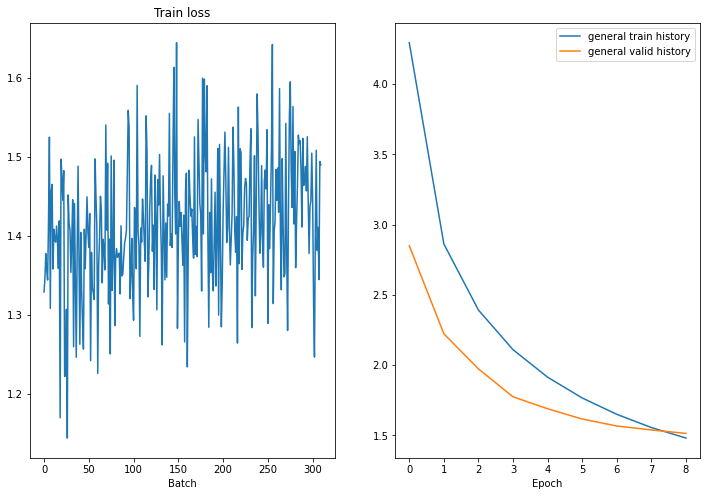

Epoch: 10 | Time: 1m 28s
	Train Loss: 1.415 | Train PPL:   4.116
	 Val. Loss: 1.486 |  Val. PPL:   4.417


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_cnn(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_cnn(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'cnn_encoder.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Again, let's take a look at our network quality__:

In [0]:
it = iter(test_iterator)

In [0]:
batch = next(it)

In [0]:
example_idx = 103

src = batch.src[example_idx:example_idx+1, :].squeeze()
trg = batch.trg[example_idx:example_idx+1, :].squeeze()

src_sent = get_text(src, SRC.vocab)
trg_sent = get_text(trg, TRG.vocab)

print(f'src = {src_sent}')
print(f'trg = {trg_sent}')

src = ['предоставляются', 'гладильные', 'принадлежности', '.']
trg = ['ironing', 'facilities', 'are', 'available', '.']


In [0]:
translation = translate_sentence(src, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['ironing', 'facilities', 'are', 'available', '.']


In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = translate_sentence_batch(src, TRG, model, device) #turn off teacher forcing
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy()])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy()])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:38,  1.52it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

33.73211458420787